## Fish in a pond estimate

Assume we have a pond with an unknown number of fish. We put a marker on a number of the fish (say 100) in the pond and release them back to the pond. Later on we catch 22 fish from the pond and measure that 9 out of 22 have the mark. What can we deduct on the total number of fish in the pond?

In [59]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [60]:
M = 100
n = 22
X = 9

In [61]:
print(M, n, X)
print(X/n)
print(M/(X/n))

100 22 9
0.4090909090909091
244.44444444444443


In [62]:
# Wilson Score Interval
z = 1.96  # For a 95% confidence interval
p_hat_adjusted = (X + z**2/2) / (n + z**2)
margin_of_error = z * np.sqrt(p_hat_adjusted * (1 - p_hat_adjusted) / n)
N_confidence_interval = (M/(p_hat_adjusted - margin_of_error), M/(p_hat_adjusted + margin_of_error))
print('The estimated CI using Wilson Score Interval is: [', f'{N_confidence_interval[1]:.1f}', ', ', 
      f'{N_confidence_interval[0]:.1f}', ']\n\n')

The estimated CI using Wilson Score Interval is: [ 159.0 ,  462.6 ]




## Bootstrap method to find the CI

In this method, we take the $n (=22)$ samples, and we resample from that, with replacement. We repeat this many times and create a distribution. This distribution resembles the distribution of the population.

We then find the 95% interval for this distribution, that is the lower bound of 2.5% and the upper bound of 97.5%.

This would be the estimated Confidence Interval, using the Bootstrap method.

In [63]:
T = 100000
x = []
for i in range(T):
    d = np.random.choice([0, 1], size=n, p=[X/n, 1-(X/n)])
    x.append(sum(d))

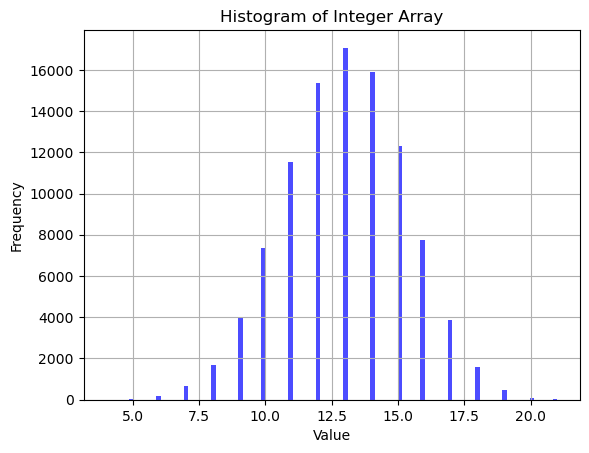

In [6]:
# Assuming 'x' is your integer array
plt.hist(x, bins='auto', color='blue', alpha=0.7)
plt.title("Histogram of Integer Array")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()

In [7]:
my_percentiles = np.percentile(x, [97.5, 2.5])
print(my_percentiles)

[17.  8.]


In [8]:
N_CI = M/(my_percentiles/n)
print('The estimated CI using Wilson Score Interval is: [', f'{N_CI[0]:.1f}', ', ', 
      f'{N_CI[1]:.1f}', ']\n\n')

The estimated CI using Wilson Score Interval is: [ 129.4 ,  275.0 ]




# Full simulation

This time, we consider a range of meaningful values for $N$, and for each value, we do many iterations of the simulation. Each iteration involves assuming the value for $N$, making $n$ draws and counting how many marked fish were among them. This gives us a probability value of $p$ that we can now plot over all values of $N$ and find the confidence interval.

In [48]:
T = 20000
Marked = np.zeros(T)

Ex = pd.DataFrame({'N': np.arange(M, 1001)})
Ex['P'] = 0 # np.zeros(Ex.shape[0])

for i in range(Ex.shape[0]):
    Samp = np.zeros(Ex.N[i])
    Samp[:M] = 1
    for t in range(T):
        Marked[t] = np.sum(np.random.choice(Samp, n, replace=False))
    bingo = (Marked == X)
    pr = np.sum(bingo) / T
    Ex.P[i] = pr

Ex.P /= sum(Ex.P)

/tmp/ipykernel_827/635272114.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '5e-05' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Ex.P[i] = pr


In [57]:
Ex.head(50)

,N,P
0,100,0.000000
1,101,0.000000
2,102,0.000000
3,103,0.000000
4,104,0.000000
5,105,0.000000
6,106,0.000000
7,107,0.000000
8,108,0.000000
9,109,0.000000


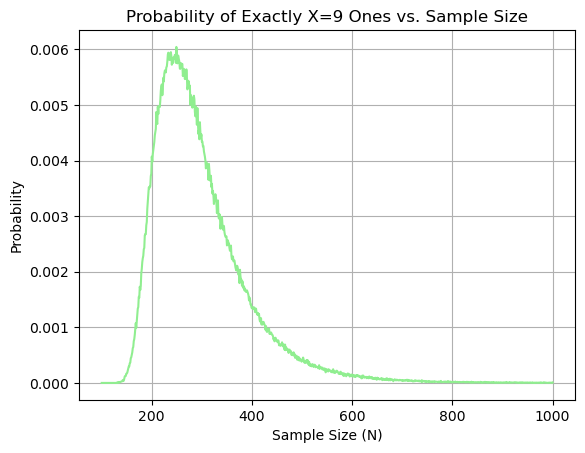

In [50]:
plt.plot(Ex.N, Ex.P, color='lightgreen')
plt.grid()
plt.xlabel("Sample Size (N)")
plt.ylabel("Probability")
plt.title("Probability of Exactly X=9 Ones vs. Sample Size")
plt.show()

In [51]:
cdf = np.cumsum(Ex.P)

In [52]:
index_025 = np.argmin(np.abs(cdf - 0.025))
index_975 = np.argmin(np.abs(cdf - 0.975))
print(Ex.N[index_025], Ex.N[index_975])

178 536


# Analythic method based on Bayes theorem

Instead of simulation, we can use an analytical approach to derive an exact solution.

The Bayesian probability formula states: $P(A|B) = P(B|A) * P(A) / P(B)$.

We want to find $P(N | 9-out-of-22)$, while we have a closed form for the $P(9-out-of-22 | N)$; and that is: $C(22, 9) \cdot p^9 \cdot (1-p)^{13}$.

Using Bayes, we write: $P(N | 9-out-of-22) = P(9-out-of-22 | N) * P(N) / P(9-out-of-22)$.

We might need more insight for the $P(N)$ term, as a subject matter expert might already have an <it>a priori</it> opinion on this part. However, the $P(9-out-of-22)$ part is independent of $N$ and hence can be simplified later on.

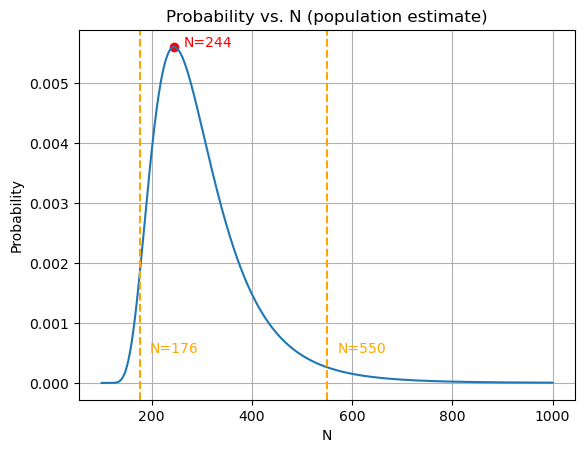

In [47]:
# Define the function to calculate the probability
# NB: we ignore the constants, as we later normalize anyway

def calculate_probability(nn, M, X, n):
    p = M / nn
    return (p**X) * ((1 - p)**(n-X)) # * stats.norm.pdf(nn, loc=600, scale=200)

# Create the array of sample sizes
N = np.arange(M, 10*M+1)

# Calculate the probabilities for each sample size
P = np.array([calculate_probability(nn, M, X, n) for nn in N])

# Normalize the probabilities
P /= np.sum(P)

# Define the function to find the percentile
def find_percentile(P, N, perc):
    cumulative_prob = 0
    for i in range(len(N)):
        cumulative_prob += P[i]
        if cumulative_prob >= perc:
            return N[i]
    return None

# Find the 2.5th and 97.5th percentiles
percentile_025 = find_percentile(P, N, 0.025)
percentile_975 = find_percentile(P, N, 0.975)

# Plot the results
plt.plot(N, P)
plt.xlabel("N")
plt.ylabel("Probability")
plt.title("Probability vs. N (population estimate)")
plt.grid(True)

# Mark the maximum probability point
max_index = np.argmax(P)
plt.scatter(N[max_index], P[max_index], color='red')
plt.text(N[max_index] + 20, P[max_index], f"N={N[max_index]}", color='red')

# Draw vertical lines for the percentiles
plt.axvline(x=percentile_025, color='orange', linestyle='--')
plt.axvline(x=percentile_975, color='orange', linestyle='--')
plt.text(percentile_025 + 20, 0.0005, f"N={percentile_025}", color='orange')
plt.text(percentile_975 + 20, 0.0005, f"N={percentile_975}", color='orange')

plt.show()